# Introduction

Credit risk is one of the risk faced by financial institutions when providing loan service. It is hard to eliminate the risk but finance institutions because of the uncertainty but the risk can reduce through higher interest rates on loans and perform a credit risk assessment before approving loan to minimise the severity of a loss. Machine learning can help to improve the credit risk assessment by create a predictive model using the past data. Hence, Machine Learning plays a vital role in credit risk assessment to help the company in anticipating credit risks.

In this problem, a supervised machine learning model will be trained to predict the probability of defaulted loan out of funded loans.


Time spent: 42 hours

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings 
from warnings import filterwarnings
filterwarnings('ignore')

## Data Preprocessing

In [3]:
# Import data
data = pd.read_csv(r"C:\Users\User\Desktop\Online Course\Moneylion\data\loan.csv", parse_dates=['applicationDate','originatedDate'])
data.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


In [4]:
# Remove unfunded loan
data = data[data['isFunded'].eq(1)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38982 entries, 1 to 577662
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            38982 non-null  object        
 1   anon_ssn                          38982 non-null  object        
 2   payFrequency                      38982 non-null  object        
 3   apr                               38982 non-null  float64       
 4   applicationDate                   38982 non-null  datetime64[ns]
 5   originated                        38982 non-null  bool          
 6   originatedDate                    38982 non-null  datetime64[ns]
 7   nPaidOff                          38961 non-null  float64       
 8   approved                          38982 non-null  bool          
 9   isFunded                          38982 non-null  int64         
 10  loanStatus                        38982 non-n

In [5]:
# Count the missing value in every column
data.isnull().sum()

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
originated                             0
originatedDate                         0
nPaidOff                              21
approved                               0
isFunded                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               9
clarityFraudId                      6622
hasCF                                  0
dtype: int64

Just drop the missing values of `nPaidOff` since there is only 21 missing values out of 38983 data.

In [6]:
data = data[data['nPaidOff'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38961 entries, 1 to 577662
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            38961 non-null  object        
 1   anon_ssn                          38961 non-null  object        
 2   payFrequency                      38961 non-null  object        
 3   apr                               38961 non-null  float64       
 4   applicationDate                   38961 non-null  datetime64[ns]
 5   originated                        38961 non-null  bool          
 6   originatedDate                    38961 non-null  datetime64[ns]
 7   nPaidOff                          38961 non-null  float64       
 8   approved                          38961 non-null  bool          
 9   isFunded                          38961 non-null  int64         
 10  loanStatus                        38961 non-n

In [7]:
# Get percentage count of loanStatus
data['loanStatus'].value_counts(normalize=True)

Paid Off Loan                  0.293165
External Collection            0.290547
New Loan                       0.208208
Internal Collection            0.142809
Returned Item                  0.030338
Settlement Paid Off            0.018121
Settled Bankruptcy             0.008342
Pending Paid Off               0.004338
Charged Off Paid Off           0.004081
Settlement Pending Paid Off    0.000026
Charged Off                    0.000026
Name: loanStatus, dtype: float64

### Create a new label variable
The label variable of this problem is `loanStatus`. Before using it, the data need to convert categorical form. But some of the values of loanStatus are lack of information. Hence, only the values seem self-explanatory will be used to create the new label variable.

The data will convert into two classes:
- Class 0: if the loan was paid
- Class 1: if the load was defaulted

For Class 0, only the following values will be considering:
- Paid Off Loan
- Settlement Paid Off

For Class 1, only the following values will be considering:
- Settled Bankruptcy
- Charged Off


In [8]:
#Save labels
labels = {1: ['Settled Bankruptcy','Charged Off'], 
          0:['Paid Off Loan','Settlement Paid Off']}

# Map labels
def map_label(data):
    for column,item in labels.items():
        if data in item:
            return column

In [9]:
data['isDefault'] = data['loanStatus'].map(map_label)
trainData = data[data['isDefault'].notna()].reset_index(drop=True)
trainData['isDefault'] = trainData['isDefault'].astype(int)
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12454 entries, 0 to 12453
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            12454 non-null  object        
 1   anon_ssn                          12454 non-null  object        
 2   payFrequency                      12454 non-null  object        
 3   apr                               12454 non-null  float64       
 4   applicationDate                   12454 non-null  datetime64[ns]
 5   originated                        12454 non-null  bool          
 6   originatedDate                    12454 non-null  datetime64[ns]
 7   nPaidOff                          12454 non-null  float64       
 8   approved                          12454 non-null  bool          
 9   isFunded                          12454 non-null  int64         
 10  loanStatus                        12454 non-nu

In [10]:
# get percentage count of new label variable
trainData['isDefault'].value_counts(normalize=True)

0    0.973824
1    0.026176
Name: isDefault, dtype: float64

The dataset is imblanced since most of the data is under Class 0

## Data Exploration


In [11]:
#list statistics of all features except loanId, clarityFraudId and anon_ssn
vars = ['loanId','clarityFraudId','anon_ssn']
for x in trainData.columns.difference(vars):
    print(x)
    print('-'*100)
    if trainData[x].dtype != 'object':
        print(trainData.groupby('isDefault')[x].describe(percentiles=[.25,.5,.75,.95,.99]))
        print('*'*100)
    else:
        print(trainData.groupby('isDefault')[x].value_counts(normalize=True, ascending=False, sort=True).unstack())

applicationDate
----------------------------------------------------------------------------------------------------
           count unique                     top freq                   first  \
isDefault                                                                      
0          12128  12127 2015-02-20 17:16:24.718    2 2014-12-04 21:30:27.564   
1            326    326 2017-01-11 08:54:04.639    1 2015-02-13 18:35:34.286   

                             last  
isDefault                          
0         2017-03-18 23:34:27.369  
1         2017-03-17 20:49:59.334  
****************************************************************************************************
approved
----------------------------------------------------------------------------------------------------
           count unique   top   freq
isDefault                           
0          12128      1  True  12128
1            326      1  True    326
***********************************************************

There is few information can understand from the statistics:
1. 14% of defaulted loan is rejected for first payment which means the payment of loan was unsuccessful. For paid loan, there are only 2% of loan is rejected for first payment.
2. 46% of defaulted loan has a `byMandatory` lead type which means bank	verification had performed before loan approval.
3. 5.5% of defaulted loan is from preselected customers who have been offered a loan through direct mail campaigns.
4. Only 0.9% of defaulted loan is come from customers who have at least	1	paid off loan in another loan portfolio where 5 % of paid loan come from customers who have at least 1 paid off loan.
5. The `leadCost` of defaulted loan has higher mean than the `leadCost` of pain loan.
6. Customers have defaulted loan have a lower mean of `nPaidOff` compared with customer have paid loan.




### Merge with clarityfraud data

Use the `clearfraudscore` from **clarityfraud** data to provide more information.

In [12]:
clarityFraud = pd.read_csv(r"C:\Users\User\Desktop\Online Course\Moneylion\data\clarity_underwriting_variables.csv")
clarityFraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

In [13]:
trainData = trainData.merge(clarityFraud[['underwritingid','clearfraudscore']], 
                    left_on='clarityFraudId', 
                    right_on='underwritingid', 
                    how='left')
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454 entries, 0 to 12453
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            12454 non-null  object        
 1   anon_ssn                          12454 non-null  object        
 2   payFrequency                      12454 non-null  object        
 3   apr                               12454 non-null  float64       
 4   applicationDate                   12454 non-null  datetime64[ns]
 5   originated                        12454 non-null  bool          
 6   originatedDate                    12454 non-null  datetime64[ns]
 7   nPaidOff                          12454 non-null  float64       
 8   approved                          12454 non-null  bool          
 9   isFunded                          12454 non-null  int64         
 10  loanStatus                        12454 non-nu

<AxesSubplot:xlabel='clearfraudscore', ylabel='Density'>

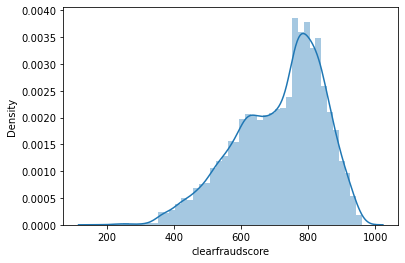

In [14]:
#visualise clearfraudscore
sns.distplot(trainData.loc[trainData['clearfraudscore'].notna(), 'clearfraudscore'])

<AxesSubplot:xlabel='isDefault', ylabel='clearfraudscore'>

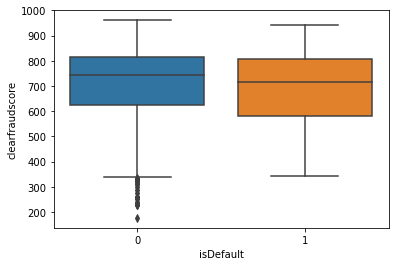

In [15]:
sns.boxplot(x = 'isDefault',
            y="clearfraudscore",
            data=trainData.loc[trainData['clearfraudscore'].notna()])

<AxesSubplot:xlabel='nPaidOff', ylabel='clearfraudscore'>

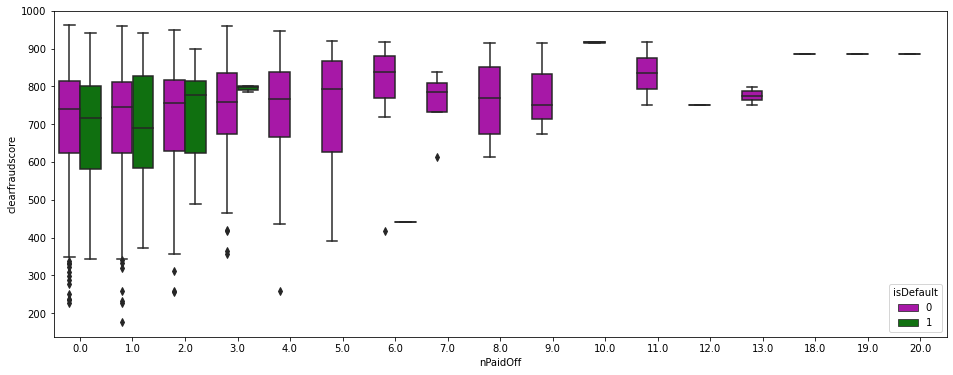

In [16]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="nPaidOff", y="clearfraudscore",
            hue="isDefault", palette=["m", "g"],
            data=trainData[trainData['clearfraudscore'].notna()])

The first graph showed that `clearfraudscore` is a left skewed variable. Besides that, the defaulted loan has higher minimum value for fraud score compared with paid loan which shown in the second graph. Lastly, the `nPaidOff` of defaulted loan are less than 4 times but paid loan has the `nPaidOff` up to 13 times.

## Feature Engineering

After exploring the data, few new variables need to create to transform raw data into features that better represent the underlying problem to the predictive models.

In [17]:
# Count Loan by using SSN
trainData['countLoan'] = trainData['anon_ssn'].map(trainData.groupby('anon_ssn')['loanId'].count()).astype(int)
trainData.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,isDefault,underwritingid,clearfraudscore,countLoan
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0,1
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0,4
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0,1
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,WI,organic,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0,3
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,MO,bvMandatory,6,Rejected,NaN,0,0,NaN,NaN,1


<AxesSubplot:xlabel='isDefault', ylabel='countLoan'>

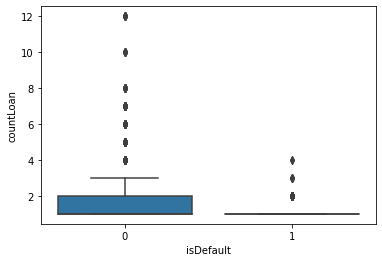

In [18]:
sns.boxplot(x = 'isDefault',
            y="countLoan",
            data=trainData)

The box plot shows that the `countLoan` between two classes have very big difference. Class 0 have higher `countLoan` compared to Class 1. The defaulted loans motsly come from new customers.

In [19]:
# count past paid loan by client
trainData['countPaidOff'] = trainData['anon_ssn'].map(data.groupby('anon_ssn')['nPaidOff'].sum()).astype(int)
trainData.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadType,leadCost,fpStatus,clarityFraudId,hasCF,isDefault,underwritingid,clearfraudscore,countLoan,countPaidOff
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0,1,0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0,4,6
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0,1,1
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,organic,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0,3,14
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,bvMandatory,6,Rejected,NaN,0,0,NaN,NaN,1,1


<AxesSubplot:xlabel='isDefault', ylabel='countPaidOff'>

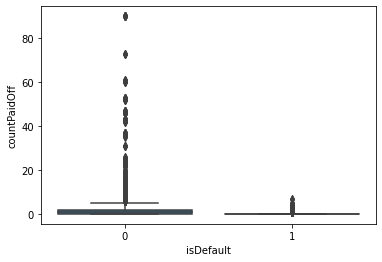

In [20]:
sns.boxplot(x = 'isDefault',
            y="countPaidOff",
            data=trainData)

Class 0 has higher `countPaidOff` than class 1 which means paid off loans are mostly come fron existing customers. 

### Merge data from payment 

The `paymentStatus` from **payment** data will be merged to count the occurence of `paymentStatus` for each `loanId`. This can helps us to understand about the payment history for each loan.

In [21]:
payment = pd.read_csv(r"C:\Users\User\Desktop\Online Course\Moneylion\data\payment.csv", parse_dates=['paymentDate'])

In [22]:
# Occurence of paymentStatus for each loanId
payment['val'] = 1

countPayment = (payment
 .pivot_table(index=['loanId'], columns=['paymentStatus'], values='val', aggfunc=sum, fill_value=0)
 .reset_index())

print(countPayment)

paymentStatus         loanId  Cancelled  Checked  Complete  None  Pending  \
0              LL-I-00000021          0       12         0     0        0   
1              LL-I-00000231          8        2         0     8        0   
2              LL-I-00000238          4        7         0     4        0   
3              LL-I-00000308         10        1         0    10        0   
4              LL-I-00000355         11        0         0    11        0   
...                      ...        ...      ...       ...   ...      ...   
39947          LP-I-00000127          0       12         0     0        0   
39948          LP-I-00000134          6        1         0     0        0   
39949          LP-I-00000139          0       12         0     0        0   
39950          LP-I-00000142         12        0         0     0        0   
39951          LP-I-00000145          0       12         0     0        0   

paymentStatus  Rejected  Rejected Awaiting Retry  Returned  Skipped  
0    

In [23]:
trainData = (trainData.merge(countPayment, on='loanId', how='left')
         .drop(['loanId'], axis=1))
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454 entries, 0 to 12453
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   anon_ssn                          12454 non-null  object        
 1   payFrequency                      12454 non-null  object        
 2   apr                               12454 non-null  float64       
 3   applicationDate                   12454 non-null  datetime64[ns]
 4   originated                        12454 non-null  bool          
 5   originatedDate                    12454 non-null  datetime64[ns]
 6   nPaidOff                          12454 non-null  float64       
 7   approved                          12454 non-null  bool          
 8   isFunded                          12454 non-null  int64         
 9   loanStatus                        12454 non-null  object        
 10  loanAmount                        12454 non-nu

### Encoding Categorical Variables
Most of the models can only read nummeric variables. Hence, string values need to encode into numeric values.

In [24]:
#import library
from sklearn.preprocessing import LabelEncoder

In [25]:
var = ['payFrequency','leadType','fpStatus','state']

unused_var = ['clarityFraudId','underwritingid','originated','approved','isFunded','loanStatus','applicationDate','originatedDate','anon_ssn']

#encode categorical data uring Label Encoder then save to a new variable
for i in var:
    lbl = LabelEncoder()
    trainData[i + '_en'] = lbl.fit_transform(trainData[i])

# drop the variables that are no information 
trainData = trainData.drop(var + unused_var, axis=1)

## Modeling

After preprocessing the data, the dataset is ready to train a machine learning model. **Gradient Boosted Decision Trees** will be used as the classifier because of the following reason:
1. Robust to outliers
2. Robust to skewness
3. Robust to null value
4. Better accuracy than any other boosting algorithm
5. Faster training speed and higher efficiency

AUC will be used to evaluate the model performance because:
1. AUC is a better performance metric than accuracy
2. AUC does not bias on size of test or evaluation data


In [26]:
# import libraries
from sklearn.model_selection import train_test_split
import lightgbm as lgb 

Split dataset into 70-30 where 70% of the data is training set and 30% of the data is testing set


In [27]:
label = trainData['isDefault']
X_train, X_valid, y_train, y_valid = train_test_split(trainData, label, test_size=0.3,stratify = label)

X_train = X_train.drop(['isDefault'], axis=1)
X_valid = X_valid.drop(['isDefault'], axis=1)

In [28]:
#construct lgb dataset
train = lgb.Dataset(X_train.values,
                           label=y_train.values)
valid = lgb.Dataset(X_valid.values,
                       label=y_valid.values)

After trying out with different number, the tuning parameter is shown below:

In [29]:
#parameter tuning
params = {
    'num_leaves': 19,
     'max_bin': 55,
     'min_data_in_leaf': 5,
     'learning_rate': 0.01,
     'min_sum_hessian_in_leaf': 0.009,
     'feature_fraction': 0.05,
     'min_gain_to_split': 0.45,
     'max_depth': 3,
     'save_binary': True,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}

In [30]:
#prepare model
model = lgb.train(params,train,
                1500, 
                valid_sets = [train, valid], 
                verbose_eval=100,
                early_stopping_rounds=500)

[LightGBM] [Info] Number of positive: 228, number of negative: 8489
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 8717, number of used features: 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's auc: 0.928368	valid_1's auc: 0.919869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

The AUC of the model is **0.88** which is high but the model is likely overfitting because the training's AUC is higher than testing's AUC. Now, the feature importance will be plotted to determine what feature is not important then remove it.

### Feature Importance

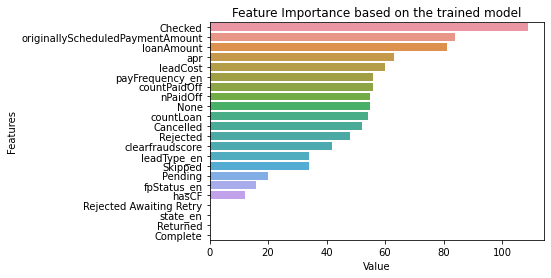

In [31]:
featureImportance = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Value','Features'])

sns.barplot(x="Value", y="Features", data=featureImportance.sort_values(by="Value", ascending=False))
plt.title('Feature Importance based on the trained model')
plt.show()

In [32]:
#remove features there are less important
unwant_feat = ['Rejected Awaiting Retry','state_en','hasCF','Returned','Complete']
trainData = trainData.drop(unwant_feat, axis=1)

In [33]:
#Split the dataset again
label = trainData['isDefault']
X_train, X_valid, y_train, y_valid = train_test_split(trainData, label, test_size=0.3,stratify = label)

X_train = X_train.drop(['isDefault'], axis=1)
X_valid = X_valid.drop(['isDefault'], axis=1)
train = lgb.Dataset(X_train.values,
                           label=y_train.values)
valid = lgb.Dataset(X_valid.values,
                       label=y_valid.values)

In [34]:
#Prepare a new model
new_model = lgb.train(params,train,
                1500, 
                valid_sets = [train, valid], 
                verbose_eval=100,
                early_stopping_rounds=500)

[LightGBM] [Info] Number of positive: 228, number of negative: 8489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 8717, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

After remove some features, the AUC of the model has increased to **0.93** but the model still overfitting. 

# Future Plan
There are few problems facing by model. First, the model is overfitting which means the the model performs well on training data but generalizes poorly to unseen data. Hence few steps can be taken to solve the problem.

Steps to handle overfitting
1. The model needs to train with more data. Because the current dataset is imbalanced. Only 2.6% of data is under the defaulted loan category. Hence, the model is may not able to classify the data very well.
2. Implement Cross-Validation on training set. we may use initial training data to generate multiple mini train-test splits. Then, use these splits to tune the model. This method can tune hyperparameters with initial training set to keep the test set as a truly unseen dataset for selecting final model.
3. Feature Selection. After training more data, maybe we can do the feature selection again. That is because the current feature importance is based on the model and it may be not accuracy due to the imbalance data.
4. Feature Engineering. Try to transform more raw data like date data into features to gain more information on the dataset. Because the current features may not enough to build a good model.
5. Try with other machine learning algorithms. Other machine learning algorithms may be work better with the current one. Hence, we may to play with other machine learning algorithms to compare the performance with current one to find out which is the best algorithm for the case.


